# Modeling

In [74]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
# train_test_split
from sklearn.model_selection import train_test_split

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re


from rdkit import Chem
from rdkit import RDLogger
import matplotlib.pyplot as plt
import pandas as pd
import gzip
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
import seaborn as sb
from itertools import chain
from rdkit.Chem import MACCSkeys
import numpy as np

RDLogger.DisableLog('rdApp.error')

# Standardization

In [2]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [5]:
# load dataset
suppl = Chem.SDMolSupplier("../data/drugbank.sdf")
drug_bank = [[mol, 'drugbank'] for mol in suppl if mol]

with gzip.open("../data/actives_final.sdf.gz") as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'actives'] for mol in supp_actives if mol]

with gzip.open("../data/decoys_final.sdf.gz") as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

df_db = pd.DataFrame(drug_bank, columns=['Mol', 'Source'])
df_ac = pd.DataFrame(actives, columns=['Mol', 'Source'])
df_dc = pd.DataFrame(decoys, columns=['Mol', 'Source'])

df = pd.concat([df_db, df_ac, df_dc], ignore_index=True)
df

,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ab90>,drugbank
1,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ac00>,drugbank
2,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ac70>,drugbank
3,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ace0>,drugbank
4,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ad50>,drugbank
...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd726c0>,decoys
42178,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72730>,decoys
42179,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd727a0>,decoys
42180,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72810>,decoys


In [6]:
# standardize and create new column 'Standardised_Mol' and mol_InChI_Key and Standardised_InChI_Key

df['Standardised_Mol'] = df['Mol'].apply(standardize)

# df['Mol_InChI_Key'] = df['Mol'].apply(lambda x: Chem.MolToInchiKey(x))
# df['Standardised_InChI_Key'] = df['Standardised_Mol'].apply(lambda x: Chem.MolToInchiKey(x) if x else None)





In [7]:
# save standardised dataset

df_standardised = df
df_standardised.to_pickle('../data/df_standardised.pkl')

In [8]:
# do some statistics how many compounds were removed by standardization and 
# how many compounds were were changed by standardization and visualize

removed = df['Standardised_Mol'].isnull().sum()
print(f'Removed: {removed}')

# from what source are the removed compounds
df.loc[df['Standardised_Mol'].isnull(), 'Source'].value_counts()
# compare mol_inchi_key and standardised_inchi_key
# number_of_changed_inchi_keys = df['Mol_InChI_Key'].ne(df['Standardised_InChI_Key']).sum()
# print(f'Number of changed InChI keys: {number_of_changed_inchi_keys}')


Removed: 1051


Source
drugbank    970
decoys       79
actives       2
Name: count, dtype: int64

In [9]:
# show sum by source
df.groupby('Source').count()


,Mol,Standardised_Mol
Source,,
actives,877,875
decoys,34188,34109
drugbank,7117,6147


In [10]:
# calculate descriptors and fingerprints MQN, ECFP
from rdkit.Chem import AllChem


df['MQN'] = df['Standardised_Mol'].apply(lambda x: rdMolDescriptors.MQNs_(x) if x else None)
df['ECFP'] = df['Standardised_Mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024) if x else None)

In [11]:
df

,Mol,Source,Standardised_Mol,MQN,ECFP
0,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ab90>,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd734c0>,"[98, 0, 0, 0, 0, 0, 0, 21, 3, 33, 0, 155, 100,...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ac00>,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd73e60>,"[59, 0, 0, 0, 0, 0, 0, 13, 5, 14, 0, 91, 53, 1...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ac70>,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92ecdbc040>,"[46, 0, 0, 0, 0, 2, 0, 8, 6, 12, 0, 74, 28, 12...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ace0>,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92ecdbc190>,"[70, 0, 1, 0, 0, 0, 0, 15, 2, 14, 0, 102, 60, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<rdkit.Chem.rdchem.Mol object at 0x7f92ed70ad50>,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92ecdbc2e0>,"[62, 0, 0, 0, 0, 0, 0, 0, 11, 12, 0, 85, 40, 1...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd726c0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e570>,"[21, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 26, 13, 2, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42178,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72730>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e810>,"[19, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 25, 10, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42179,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd727a0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f5a0>,"[17, 2, 0, 0, 0, 1, 0, 2, 0, 3, 0, 25, 12, 2, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42180,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72810>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f6f0>,"[16, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 24, 12, 2, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [34]:
# drop drugbank compoundsand create df_actives_decoys
df_actives_decoys = df.loc[df['Source'] != 'drugbank']

In [35]:
df_actives_decoys

,Mol,Source,Standardised_Mol,MQN,ECFP
7117,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff530>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9e570>,"[22, 0, 1, 0, 0, 0, 0, 2, 1, 3, 0, 29, 10, 2, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7118,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff5a0>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9d930>,"[27, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 37, 15, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7119,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff610>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9e730>,"[27, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 37, 15, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7120,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff680>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9c3c0>,"[26, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 31, 10, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
7121,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff6f0>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9c580>,"[32, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 37, 11, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd726c0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e570>,"[21, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 26, 13, 2, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42178,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72730>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e810>,"[19, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 25, 10, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42179,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd727a0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f5a0>,"[17, 2, 0, 0, 0, 1, 0, 2, 0, 3, 0, 25, 12, 2, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42180,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72810>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f6f0>,"[16, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 24, 12, 2, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [36]:
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
df_actives_decoys['ECFP'].isnull().sum()
df_actives_decoys['MQN'].isnull().sum()
# drop rows with null values 
df_actives_decoys = df_actives_decoys.dropna(subset=['ECFP', 'MQN'])
df_actives_decoys

,Mol,Source,Standardised_Mol,MQN,ECFP
7117,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff530>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9e570>,"[22, 0, 1, 0, 0, 0, 0, 2, 1, 3, 0, 29, 10, 2, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7118,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff5a0>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9d930>,"[27, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 37, 15, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7119,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff610>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9e730>,"[27, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 37, 15, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7120,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff680>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9c3c0>,"[26, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 31, 10, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
7121,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff6f0>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9c580>,"[32, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 37, 11, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd726c0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e570>,"[21, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 26, 13, 2, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42178,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72730>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e810>,"[19, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 25, 10, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42179,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd727a0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f5a0>,"[17, 2, 0, 0, 0, 1, 0, 2, 0, 3, 0, 25, 12, 2, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42180,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72810>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f6f0>,"[16, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 24, 12, 2, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
# actives will be 1 and decoys will be 0
df_actives_decoys['Activity'] = df_actives_decoys['Source'].apply(lambda x: 1 if x == 'actives' else 0)

/tmp/ipykernel_13468/2773851340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives_decoys['Activity'] = df_actives_decoys['Source'].apply(lambda x: 1 if x == 'actives' else 0)


In [39]:
df_actives_decoys

,Mol,Source,Standardised_Mol,MQN,ECFP,Activity
7117,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff530>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9e570>,"[22, 0, 1, 0, 0, 0, 0, 2, 1, 3, 0, 29, 10, 2, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7118,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff5a0>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9d930>,"[27, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 37, 15, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7119,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff610>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9e730>,"[27, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 37, 15, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7120,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff680>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9c3c0>,"[26, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 31, 10, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",1
7121,<rdkit.Chem.rdchem.Mol object at 0x7f92ed4ff6f0>,actives,<rdkit.Chem.rdchem.Mol object at 0x7f92ecc9c580>,"[32, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 37, 11, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...
42177,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd726c0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e570>,"[21, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 26, 13, 2, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
42178,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72730>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86e810>,"[19, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 25, 10, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
42179,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd727a0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f5a0>,"[17, 2, 0, 0, 0, 1, 0, 2, 0, 3, 0, 25, 12, 2, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
42180,<rdkit.Chem.rdchem.Mol object at 0x7f92ecd72810>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f92ec86f6f0>,"[16, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 24, 12, 2, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [40]:
x_train = np.array(df_actives_decoys['ECFP'].tolist())
y_train = np.array(df_actives_decoys['Activity'].tolist())  


In [41]:
# use fast classifier 
rf = ensemble.RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [42]:
y_pred = rf.predict(x_train)

In [44]:
# calculate F1 score
from sklearn.metrics import f1_score
f1_score(y_train, y_pred)




0.9965596330275229

In [45]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[34109,     0],
       [    6,   869]])

In [50]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [65]:
mols=[]
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
with open("../data/chembl_drd3_ic50.csv") as inp:
    for row in csv.DictReader(inp, delimiter=";", quotechar='"'):
        row["rdmol"] = Chem.MolFromSmiles(row["Smiles"])
        row["smiles"] = row["Smiles"]
        row["source"] = "mtor"
        row["pChEMBL_value"] = float(row["pChEMBL Value"]) if float_pattern.match(row["pChEMBL Value"]) else 0
        
        mol = standardize(row["rdmol"])
        if mol and row["pChEMBL_value"]:
            fp = AllChem.GetMorganFingerprintAsBitVect(row["rdmol"],2,nBits=1024)
            mols.append({
                    "smiles": Chem.MolToSmiles(mol),
                     "source":"mtor",
                     "rdmol": mol,
                     "pChEMBL_value": row["pChEMBL_value"],
                     # Chem.MolToInchiKey(mol),
                     "fps": fp
                    }
                )

In [66]:
drd3 = pd.DataFrame(mols, columns=["smiles","source", "rdmol", "fps", "pChEMBL_value"])
# adds index as normal column
drd3.reset_index(level=0, inplace=True)

In [69]:
drd3 = drd3.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in drd3["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [81]:
drd3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          369 non-null    int64  
 1   smiles         369 non-null    object 
 2   source         369 non-null    object 
 3   rdmol          369 non-null    object 
 4   fps            369 non-null    object 
 5   pChEMBL_value  369 non-null    float64
 6   MQN_1          369 non-null    int64  
 7   MQN_2          369 non-null    int64  
 8   MQN_3          369 non-null    int64  
 9   MQN_4          369 non-null    int64  
 10  MQN_5          369 non-null    int64  
 11  MQN_6          369 non-null    int64  
 12  MQN_7          369 non-null    int64  
 13  MQN_8          369 non-null    int64  
 14  MQN_9          369 non-null    int64  
 15  MQN_10         369 non-null    int64  
 16  MQN_11         369 non-null    int64  
 17  MQN_12         369 non-null    int64  
 18  MQN_13    

In [82]:
drd3_train, drd3_test = train_test_split(drd3, test_size=0.3, random_state=42)


In [83]:
rr = ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
rr.fit(list(drd3_train["fps"]), drd3_train["pChEMBL_value"])

RandomForestRegressor(random_state=42)

In [84]:
y_pred = rr.predict(list(drd3_test["fps"]))

In [85]:
# mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(drd3_test["pChEMBL_value"], y_pred)

0.6009849036981757

<Axes: ylabel='pChEMBL_value'>

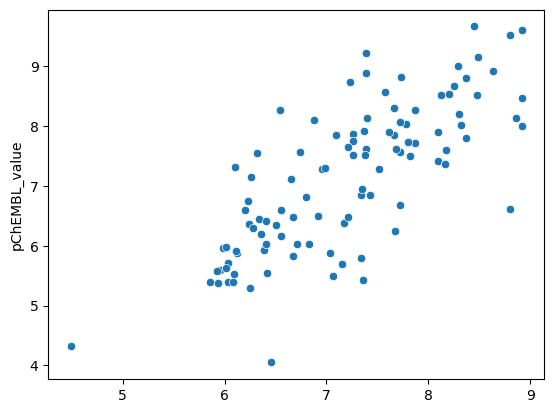

In [86]:
seaborn.scatterplot(x = y_pred, y=drd3_test["pChEMBL_value"])

<Axes: ylabel='pChEMBL_value'>

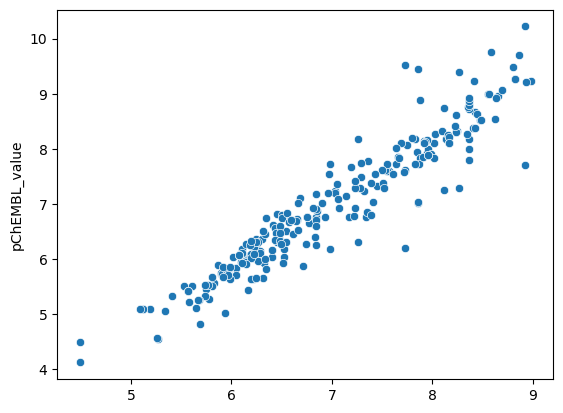

In [87]:
seaborn.scatterplot(x = rr.predict(list(drd3_train["fps"])), y=drd3_train["pChEMBL_value"])